# multi-label tweets classification:

In [1]:
import pandas as pd
import json
import torch   
from torchtext import data 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import os
from torchtext.vocab import Vectors # downloaded word embedding
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from ast import literal_eval # convert string to list
from sklearn.preprocessing import MultiLabelBinarizer
import re

import torch.nn.functional as F
from torch.autograd import Variable

### convert list into columns in dataframe:

In [2]:
# read dataset and testset.
dataset = pd.read_csv("pre-processed data/new_label_dataset.csv")[['content', 'categories']]
testset = pd.read_csv("pre-processed data/new_label_testset.csv")[['content', 'categories']]

# convert string to list.
dataset['categories'] = dataset['categories'].apply(lambda x:literal_eval(x))
testset['categories'] = testset['categories'].apply(lambda x:literal_eval(x))

# seperate 'categories' column.
cat_tr_list = []
for i in dataset['categories']:
    cat_tr_list.append(i)
    
cat_te_list = []
for i in testset['categories']:
    cat_te_list.append(i)

mlb_tr = MultiLabelBinarizer()
labels_tr = mlb_tr.fit_transform(cat_tr_list)
categories_tr = mlb_tr.classes_

mlb_te = MultiLabelBinarizer()
labels_te = mlb_te.fit_transform(cat_te_list)
categories_te = mlb_te.classes_

# convert list to columns.
for i, cat in enumerate(categories_tr):
    dataset[cat] = labels_tr[:, i]
    

for i, cat in enumerate(categories_te):
    testset[cat] = labels_te[:, i]
    
    
dataset.to_csv("pre-processed data/new_label_dataset_1.csv")
testset.to_csv("pre-processed data/new_label_testset_1.csv")

In [3]:
testset[:1]

,content,categories,Advice,CleanUp,ContextualInformation,Discussion,Donations,EmergingThreats,Factoid,FirstPartyObservation,...,NewSubEvent,News,Official,OriginalEvent,SearchAndRescue,Sentiment,ServiceAvailable,ThirdPartyObservation,Volunteer,Weather
0,view shell gregoire,"[FirstPartyObservation, Location, EmergingThre...",0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dataset[:1]

,content,categories,Advice,CleanUp,ContextualInformation,Discussion,Donations,EmergingThreats,Factoid,FirstPartyObservation,...,NewSubEvent,News,Official,OriginalEvent,SearchAndRescue,Sentiment,ServiceAvailable,ThirdPartyObservation,Volunteer,Weather
0,philippine flood worsen death toll hit wake ge...,"[ThirdPartyObservation, Factoid, News]",0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0


In [5]:
# for imbalance dataset. reduction = 'none' in loss function.
weight = torch.tensor(labels_tr.sum(axis=0)/sum(labels_tr.sum(axis=0)))

weight

tensor([0.0213, 0.0016, 0.0224, 0.0324, 0.0110, 0.0178, 0.0798, 0.0559, 0.0019,
        0.0807, 0.0026, 0.0844, 0.0742, 0.0022, 0.1038, 0.0089, 0.1129, 0.0180,
        0.0316, 0.0032, 0.0994, 0.0169, 0.0811, 0.0019, 0.0338],
       dtype=torch.float64)

### torchtext:
<img src="image/torchtext.png" width="600">

torchtext.data
>
>* Field: 
* TabularDataset: 
* Example
* Iterator (Iterator, BucketIterator, BPTTIterator)

In [6]:
torch.manual_seed(2020)

# the same as system_2.
TEXT = data.Field(sequential=True, tokenize=lambda x: x.split(), lower=True)
LABEL = data.Field(sequential=False, use_vocab=False)

fields = [(v, LABEL) for v in categories_tr]

fields = [(None, None), ('content', TEXT), (None, None)] + fields

tr_X, te_X = data.TabularDataset.splits(
    path = 'pre-processed data/',
    train = 'new_label_dataset_1.csv',
    test = 'new_label_testset_1.csv',
    format = 'csv',
    fields = fields,
    skip_header = True
)

In [7]:
print(vars(tr_X.examples[0]))
print(vars(te_X.examples[0]))

{'content': ['philippine', 'flood', 'worsen', 'death', 'toll', 'hit', 'wake', 'gener'], 'Advice': '0', 'CleanUp': '0', 'ContextualInformation': '0', 'Discussion': '0', 'Donations': '0', 'EmergingThreats': '0', 'Factoid': '1', 'FirstPartyObservation': '0', 'GoodsServices': '0', 'Hashtags': '0', 'InformationWanted': '0', 'Irrelevant': '0', 'Location': '0', 'MovePeople': '0', 'MultimediaShare': '0', 'NewSubEvent': '0', 'News': '1', 'Official': '0', 'OriginalEvent': '0', 'SearchAndRescue': '0', 'Sentiment': '0', 'ServiceAvailable': '0', 'ThirdPartyObservation': '1', 'Volunteer': '0', 'Weather': '0'}
{'content': ['view', 'shell', 'gregoire'], 'Advice': '0', 'CleanUp': '0', 'ContextualInformation': '0', 'Discussion': '0', 'Donations': '0', 'EmergingThreats': '1', 'Factoid': '0', 'FirstPartyObservation': '1', 'GoodsServices': '0', 'Hashtags': '0', 'InformationWanted': '0', 'Irrelevant': '0', 'Location': '1', 'MovePeople': '0', 'MultimediaShare': '1', 'NewSubEvent': '0', 'News': '0', 'Official

### use downloaded word embedding:

In [8]:
# tr_X, te_X = dataset.split(split_ratio=0.8, random_state = random.seed(2020))
# tr_x, val_x = tr_X.split(split_ratio=0.7, random_state = random.seed(2020))

# load downloaded glove word embedding.
cache = '.vector_cache'
if not os.path.exists(cache): os.mkdir(cache)
vectors = Vectors(name='./glove.840B.300d.txt', cache=cache)

# create vocab.
TEXT.build_vocab(tr_X, min_freq=3, vectors=vectors)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

print("Top words: ", TEXT.vocab.freqs.most_common(5))  

Size of TEXT vocabulary: 6392
Top words:  [('earthquake', 2846), ('school', 2577), ('shoot', 2453), ('nepal', 2414), ('philippine', 2358)]


### BucketIterator:

通过sort_key，BucketIterator将长度相近的数据放到同一个batch内来sample，这样可以最小化每个batch需要padding的个数，提高计算效率。

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits((tr_X, te_X), 
                                                            batch_sizes = (64, 64),
                                                            sort_key = lambda x: len(x.content),
                                                            sort_within_batch=False,
                                                            repeat=False,
                                                            device=device)

### python - yield:

**yield** keyword means this function is a generator.

In [10]:
class BatchWrapper:
    def __init__(self, dl, x_var, y_vars):
            self.dl, self.x_var, self.y_vars = dl, x_var, y_vars # x_var is content, y_var is label.

    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var) # return value of x_var "content" in object batch.
            y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim=1).float()
            yield (x, y)

    def __len__(self):
            return len(self.dl)

train_dl = BatchWrapper(train_iterator, "content", list(categories_tr))
valid_dl = BatchWrapper(valid_iterator, "content", list(categories_tr))

### nn.RELU and F.RELU

nn.ReLU作为一个层结构，必须添加到nn.Module容器中才能使用，而F.ReLU则作为一个函数调用。

In [11]:
class GRU(nn.Module):
    def __init__(self, hidden_dim=30, emb_dim=300):
        super().__init__()
        
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.gru = nn.GRU(emb_dim, hidden_dim, num_layers=1, dropout=0.2, bidirectional = True)
        self.fc = nn.Linear(hidden_dim*2, 64)
        self.fc1 = nn.Linear(64, 25)

    def forward(self, seq):
        embed = self.embedding(seq)
        _, hidden = self.gru(embed)
        embed1 = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        output = self.fc(embed1)
        output1 = self.fc1(F.relu(output))
        preds = output1 # BCEWithlogitsLoss = sigmoid + BCELoss
        return preds

### reduction = 'none', 'elementwise_mean' and 'sum'

>* elementwise_mean: (default) the average of sum of loss.
* sum: the sum of loss.
* none: don't process.

In [19]:
def SGD(epochs=10, hidden_dim = 30):
    
    tr_loss_list, te_loss_list = [], []
    
    model = GRU(hidden_dim, emb_dim=300)

    optimizer = optim.SGD(model.parameters(), lr=0.1)
    criterion = nn.BCEWithLogitsLoss(reduction='none')
    # nn.MultiLabelSoftMarginLoss() nn.BCELoss()

    # pre-trained Glove.
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data.copy_(pretrained_embeddings)

    for epoch in range(epochs):
        tr_loss, val_loss = 0.0, 0.0
        
        # training 
        model.train() 
        for x, y in train_dl: 
            optimizer.zero_grad()
            preds = model(x).squeeze()
            print(preds.shape)
            loss = criterion(preds, y) # 
            loss = (loss * weight).mean()
            print(loss)
            loss.backward()
            optimizer.step()
            tr_loss += loss.item()*64

        tr_loss /= len(train_dl)

        # testing
        model.eval()
        target_list, preds_list = [], []
        with torch.no_grad():
            for x, y in valid_dl:
                preds = model(x).squeeze()
                loss = criterion(preds, y) # 
                loss = (loss * weight).mean()
                preds = (1/(1 + np.exp(-preds))).numpy() # preds.numpy()
                preds_list.extend(preds)
                target_list.extend(y.numpy())
                val_loss += loss.item()*64

        val_loss /= len(valid_dl)
        
        tr_loss_list.append(tr_loss)
        te_loss_list.append(val_loss)

        print('Epoch: ',epoch,' Training Loss: ',tr_loss,' | Validation Loss: ',val_loss)
        
        if len(te_loss_list) > 2:
            if (te_loss_list[-2] - te_loss_list[-1]) > 0 and (te_loss_list[-2] - te_loss_list[-1]) < 0.0001:
                break
        
    return target_list, preds_list, tr_loss_list, te_loss_list

In [20]:
# hyper-parameter choosing and test model performace.

target_list, preds_list, tr_loss, te_loss = SGD(50, 300)

torch.Size([64, 25])
tensor(0.0276, dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([64, 25])
tensor(0.0276, dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([64, 25])
tensor(0.0275, dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([64, 25])
tensor(0.0276, dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([64, 25])
tensor(0.0276, dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([64, 25])
tensor(0.0276, dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([64, 25])
tensor(0.0276, dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([64, 25])
tensor(0.0275, dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([64, 25])
tensor(0.0275, dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([64, 25])
tensor(0.0275, dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([64, 25])
tensor(0.0276, dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([64, 25])
tensor(0.0276, dtype=torch.float64, grad_fn=<MeanBackward0>)
torch.Size([64, 

KeyboardInterrupt: 

### Result:

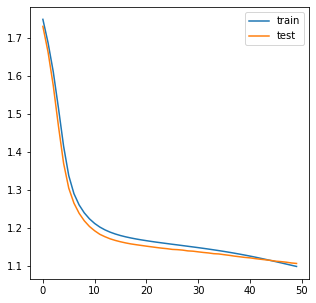

In [20]:
epoch = [i for i in range(len(tr_loss))]

plt.figure(figsize=(5,5))
plt.plot(epoch, tr_loss, label='train')
plt.plot(epoch, te_loss, label='test')
plt.legend()
plt.show()

In [18]:
preds_te_arr = np.array(preds_list).reshape((-1, 25))

preds_te_arr[preds_te_arr >= 0.5] = 1
preds_te_arr[preds_te_arr < 0.5] = 0

te_y = np.array(target_list).reshape((-1, 25))

In [19]:
preds_te_arr.shape

score = 0
acc = 0

for i in range(preds_te_arr.shape[1]):
    score += f1_score(te_y[:, i], preds_te_arr[:, i],average='macro')
    acc += accuracy_score(te_y[:, i], preds_te_arr[:, i])
    
print("Macro-average F1-score: ", score/25)
print("Average accuracy: ", acc/25)

Macro-average F1-score:  0.4735911693881784
Average accuracy:  0.9038317642743611


tutorial:

* data processing in pytorch: http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/

* imbalance dataset in pytorch: https://discuss.pytorch.org/t/multi-label-multi-class-class-imbalance/37573/9